### Import

In [ ]:
import gzip
import json
import random
import time
from nltk import word_tokenize
from tqdm import tqdm
import contractions
import pandas as pd

# Imports for the synonym dictionary 
import requests
from bs4 import BeautifulSoup
from nltk.wsd import lesk

#wordnet imports
#importing NLTK corpus synonym dictionary, pos-tagging and checking the outputs
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
import random
from sklearn.pipeline import Pipeline

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

#Word2Vec imports
import gensim.models



In [ ]:
#wordnet downloads
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
random.seed(42)

### Read in the data

In [ ]:
#here
def reading_in(path):
    thing=[]
    for line in gzip.open(path):
        review_data = json.loads(line)
        subthing = dict()
        for key in review_data:
            subthing[key]= review_data[key]
        thing.append(subthing)
    return thing

In [ ]:
train = reading_in('../data/classification/music_reviews_train.json.gz')
dev = reading_in('../data/classification/music_reviews_dev.json.gz') # do not use!
#test = reading_in('../data/classification/music_reviews_test_masked.json.gz') #do not use!
train = shuffle(train, random_state=42)

In [ ]:
train_x = [i['reviewText'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]
train_y =  [i['sentiment'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]

dev_x = [i['reviewText'] if "reviewText" in i.keys() else "" for i in dev]
dev_y = [i['sentiment'] for i in dev]

In [ ]:
pos_neg = [sum([i =="positive" for i in train_y]),sum([i != "positive" for i in train_y])]

<BarContainer object of 2 artists>

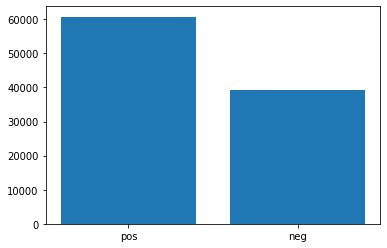

In [ ]:
import matplotlib.pyplot as plt
plt.bar(x=["pos","neg"], height = pos_neg) 

In [ ]:
###split into pos and neg
train_x_pos = []
train_x_neg = []
train_y_pos = []
train_y_neg = []
for i in range(len(train_x)):
    if train_y[i] == "positive":
        train_x_pos.append(train_x[i])
        train_y_pos.append(train_y[i])
    else:
        train_x_neg.append(train_x[i])
        train_y_neg.append(train_y[i])
train_x_neg.extend(train_x_pos[0:len(train_x_neg)])
train_y_neg.extend(train_y_pos[0:len(train_y_neg)])
balanced_x_train_s = train_x_neg
balanced_y_train_s = train_y_neg

balanced_x_train, balanced_y_train = shuffle(balanced_x_train_s, balanced_y_train_s, random_state= 42)


In [ ]:

len(train_x_neg)

78424

In [ ]:
#Tokenizer
def tokenize_corpus(corpus):
    return [contractions.fix(s) for s in corpus]


train_x = [i['reviewText'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]
train_y =  [i['sentiment'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]

dev_x = [i['reviewText'] if "reviewText" in i.keys() else "" for i in dev]
dev_y = [i['sentiment'] for i in dev]

###split into pos and neg
train_x_pos = []
train_x_neg = []
train_y_pos = []
train_y_neg = []
for i in range(len(train_x)):
    if train_y[i] == "positive":
        train_x_pos.append(train_x[i])
        train_y_pos.append(train_y[i])
    else:
        train_x_neg.append(train_x[i])
        train_y_neg.append(train_y[i])
train_x_neg.extend(train_x_pos[0:len(train_x_neg)])
train_y_neg.extend(train_y_pos[0:len(train_y_neg)])
balanced_x_train_s = train_x_neg
balanced_y_train_s = train_y_neg

balanced_x_train, balanced_y_train = shuffle(balanced_x_train_s, balanced_y_train_s, random_state= 42)

train_x_split = tokenize_corpus(balanced_x_train)

vectorizer = TfidfVectorizer()
tfid = vectorizer.fit(train_x_split)
train_x = tfid.transform(train_x_split)
print(train_x.shape)
train_x = train_x.toarray()
train_x = np.reshape(train_x, (len(train_x), train_x.shape[1], 1))
train_x = tf.convert_to_tensor(train_x)

(78424, 63058)


KernelInterrupted: Execution interrupted by the Jupyter kernel.

### Preparing the data

In [ ]:
#old tokenizer
#train_x_back = [' '.join(sen) for sen in train_x_split] may not need convertes tokenised back to single string

In [ ]:
#Tokenizer
def tokenize_corpus(corpus):
    return [word_tokenize(contractions.fix(s)) for s in corpus]

In [ ]:
train_x_split = tokenize_corpus(balanced_x_train)

# Webscrape synonyms

In [ ]:
##Alternative to PyDictionary
##THIS IS COPIED FROM SLACK
# https://stackoverflow.com/questions/52910297/pydictionary-word-has-no-synonyms-in-the-api

def synonyms(term):
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.text, 'lxml')
    soup.find('section', {'class': 'css-17ofzyv e1ccqdb60'})
    return [span.text for span in soup.findAll('a', {'class': 'css-1kg1yv8 eh475bn0'})] # 'css-1gyuw4i eh475bn0' for less relevant synonyms

word = "us"
print(synonyms(word))

['them ', 'you ']


In [ ]:
dont_replace = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will','I ', 'it ', 'she ', 'sie ', 'they ', 've ', 'xe ', 'you ', 'ze ', 'zie ','he',"you","we","mine","hers","his","yours","its","ours","theirs","your","our","oneself","oneselves","yourself","yourselves","himself","herself","himself","myself","themselves","itself","ourselves","ourself","us","them"] #Used to avoid changing function and pronouns words
def gen_synth_web(sentence,prob = 0.5):
    new_sen = []
    for word in sentence:
        if word in dont_replace:
            new_sen.append(word)
        else:
            threshold = random.random()
            if prob > threshold:
                #print(threshold) can remove later kept for debugging
                syn = synonyms(word)
                if len(syn) != 0:
                    #print("selected", word) can remove later kept for debugging
                    new_sen.append(random.choice(syn))
                else:new_sen.append(word)
            else:
                new_sen.append(word)
    return new_sen

In [ ]:
print(train_x_split[16])

['I', 'was', 'disappointed', 'in', 'this', 'CD']


In [ ]:
print(gen_synth_web(train_x_split[16]))

['I', 'was', 'disappointed', 'in', 'that ', 'CD']


In [ ]:
#for i in tqdm(train_x_split[:1000]):#running with 0:1000 dont uncomment as will mess up file 
   # with open ("../data/synthetic1.txt","a") as f:
       # f.write(' '.join(gen_synth_web(i))+"\n")
       # time.sleep(3)

#### Example of webscrape synthetic sentence 

In [ ]:
print(train_x_split[6])

['Just', 'to', 'let', 'anyone', 'know', 'before', 'purchasing', 'this', 'cd', 'like', 'myself', ',', 'You', 'should', 'know', 'its', 'a', 'blue', 'bottom', 'CDR', 'copy', 'of', 'songs', 'off', 'there', 'three', 'other', 'cd', "'s", '...', 'I', 'do', 'not', 'know', 'how', 'or', 'why', 'Amazon', 'let', 'us', 'these', 'seller', 'sell', 'these', 'because', 'it', 'is', 'not', 'legal', '.', 'It', 'comes', 'in', 'a', 'real', 'thin', 'case', 'with', 'only', 'the', 'front', 'picture', '&', 'a', 'Sharpie', 'writing', 'on', 'the', 'cd', '.', 'What', 'a', 'Joke', '&', 'waste', 'of', 'money', '!', 'I', 'got', 'the', 'other', 'cd', "'s", '&', 'i', 'can', 'make', 'mixed', 'cdr', 'copy', "'s", 'better', 'than', 'these', 'but', 'do', 'you', 'think', 'i', 'could', 'sell', 'them', '?', '?', '?', '?']


In [ ]:
print(gen_synth_web(train_x_split[16]))

['he ', 'was', 'disappointed', 'in', 'this', 'cash ']


# Wordnet

In [ ]:
relevant = ["NN","NNS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ","JJ","JJR","JJS"]#The wordclasses that can be exchanged with synonyms (not functional words) #maybe not RB
wordnet_tag_map = {'NN': ['n'],'NNS': ['n'],'JJ': ['a'],'JJR': ['a'],'JJS': ['a'],'RB': ['r'],'RBR': ['r'],'RBS': ['r'], 'VB': ['v'], 'VBG': ['v'], 'VBD': ['v'], 'VBN': ['v'], 'VBP': ['v'], 'VBZ': ['v']} #Making pos-tags coincide
aux_verbs = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will'] #Used to avoid changing function words
def change_wordnet(sentence):
    sentence = nltk.pos_tag(sentence)    #pos-tagging sentence here
    new_sentence = [] #to append to and then return as final sentence
    for word in sentence:
        if random.random()>0.5:
            if word[1] in relevant and word[0] not in aux_verbs: #Not changing functional words
                tag = wordnet_tag_map[word[1]]
                chosen = lesk(sentence, word[0], tag[0]) #from all synsets choose the most likely in a smart way, thanks to library!
                if chosen is None:
                    new_sentence.append(word[0]) #sometimes no synset is chosen so we just give the new sentence the original word
                else:
                    options = chosen.lemma_names()
                    if word[0] in options:
                        options.remove(word[0])
                    if len(options)>0:
                        chosen_w = random.choice(options)
                        if "_" in chosen_w:
                            for w in chosen_w.split("_"):
                                new_sentence.append(w)
                        else:
                            new_sentence.append(chosen_w)
                    else:
                        new_sentence.append(word[0])
            else:
                new_sentence.append(word[0])
        else:
            new_sentence.append(word[0])
    return new_sentence

#### Example of wordnet synthetic sentence 

In [ ]:
print(train_x_split[16])

['I', 'was', 'disappointed', 'in', 'this', 'CD']


In [ ]:
print(change_wordnet(train_x_split[16]))

['I', 'was', 'let', 'down', 'in', 'this', 'CD']


#### write to file

In [ ]:
wn_x_train = [change_wordnet(i) for i in train_x_split]

KeyboardInterrupt: 

In [ ]:
len(wn_x_train)

78424

In [ ]:
with open("../data/synthetic/wordnet.csv",'w') as f:
    f.writelines('\t'.join(s) + '\n' for s in wn_x_train)

# Word2vec

In [ ]:
gooEmbs.most_similar('walk')

[('walking', 0.7361534237861633),
 ('walks', 0.7007260918617249),
 ('walked', 0.6831838488578796),
 ('stroll', 0.6208134889602661),
 ('Walking', 0.5674901604652405),
 ('Walk', 0.558607280254364),
 ('wander', 0.5585978627204895),
 ('jog', 0.5467169284820557),
 ('saunter', 0.5451485514640808),
 ('amble', 0.5250112414360046)]

In [ ]:
# With a threshold and without the check of same word

gooEmbs = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-50k.bin', binary=True)
print('loading finished')
relevant = ["NN","NNS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ","JJ","JJR","JJS"]#The wordclasses that can be exchanged with synonyms (not functional words) #maybe not RB
aux_verbs = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will'] #Used to avoid changing function words
def change_word2vec(original_sentence, prob = 0.5, threshold = .6):
    sentence = nltk.pos_tag(original_sentence)    #pos-tagging sentence here
    new_sentence = [] #to append to and then return as final sentence
    for word in sentence:
        if word[1] in relevant and word[0] not in aux_verbs:
            if random.random() > prob:
                try:
                    syno = gooEmbs.most_similar(word[0]) #taking the most similar word from word2vec
                    syno_pos = []
                    # method 1: 
                    for s in syno:
                        if s[1] > threshold:
                            syno_pos.append(s)
                        else: 
                            break # because all the words are sorted we know that if one word is under 60% all the others after are also
                    if syno_pos!=[]:
                        new_word = random.choice(syno_pos)[0]
                    else:  new_word = syno[0][0]
                    if "_" in new_word:
                        for w in chosen_w.split("_"):
                            new_sentence.append(w)
                    else: new_sentence.append(new_word)                    
                except:
                    new_sentence.append(word[0])
            else: 
                new_sentence.append(word[0])
        else:
            new_sentence.append(word[0])
    return new_sentence

loading finished


In [ ]:
ori = train_x_split[20]
t8 = change_word2vec(ori, threshold=0.8)
t7= change_word2vec(ori, threshold=0.7)
t6 =change_word2vec(ori, threshold=0.6)
t5 = change_word2vec(ori, threshold=0.5)
t4 = change_word2vec(ori, threshold=0.4)
t3 = change_word2vec(ori, threshold=0.3)
t2 = change_word2vec(ori, threshold=0.2)
t1 = change_word2vec(ori, threshold= 0.1)

#for i in range(len(ori)):
 #   print(f'o: {ori[i]}, .7: {t7[i]}, .6: {t6[i]}, .5: {t5[i]}, .4 {t4[i]}, .3: {t3[i]}')

print(ori)
print(t8)
print(t7)
print(t6)
print(t5)
print(t4)
print(t3)
print(t2)
print(t1)


['Come', 'on', ',', 'after', 'the', 'intro', 'it', 'goes', 'into', 'story', 'telling', 'mode', '.', 'This', 'is', 'not', 'the', 'song', 'I', 'wanted', '.']
['Come', 'on', ',', 'after', 'the', 'outro', 'it', 'goes', 'into', 'story', 'tell', 'mode', '.', 'This', 'is', 'do', 'the', 'songs', 'I', 'want', '.']
['Come', 'on', ',', 'after', 'the', 'outro', 'it', 'comes', 'into', 'stories', 'tell', 'mode', '.', 'This', 'is', 'do', 'the', 'anthem', 'I', 'wanted', '.']
['Come', 'on', ',', 'after', 'the', 'outro', 'it', 'goes', 'into', 'stories', 'tells', 'modes', '.', 'This', 'is', 'never', 'the', 'ditty', 'I', 'wanted', '.']
['Come', 'on', ',', 'after', 'the', 'intro', 'it', 'gone', 'into', 'story', 'tell', 'mode', '.', 'This', 'is', 'necessarily', 'the', 'songs', 'I', 'wanted', '.']
['Come', 'on', ',', 'after', 'the', 'bassline', 'it', 'gets', 'into', 'backstory', 'telling', 'mode', '.', 'This', 'is', 'does', 'the', 'song', 'I', 'decided', '.']
['Come', 'on', ',', 'after', 'the', 'montage', 'i

In [ ]:

text = str()

for i in t1:
    text += ' '+i

print(text)

 Come on , after the riff it goes into article tell mode . This is not the ditty I want .


In [ ]:
print(ori)
print(t7)
print(t6)
print(t5)
print(t4)
print(t3)

['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']
['I', 'love', 'the', 'sounds', 'of', 'anybody', 'George', 'Ezra', 'sang', 'in', ';', 'remarkable', 'young', 'man', '.']
['I', 'passion', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'ballad', 'in', ';', 'impressive', 'young', 'man', '.']
['I', 'loving', 'the', 'sound', 'of', 'never', 'George', 'Ezra', 'croon', 'in', ';', 'remarkable', 'young', 'man', '.']
['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'startling', 'young', 'guy', '.']
['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'men', '.']


In [ ]:
#new_x = []
#for  i in train_x[:1000]:
    #new_x.append(change_word2vec(i))

In [ ]:
print(train_x_split[16])
print(gen_synth_web(train_x_split[16]))
print(change_wordnet(train_x_split[16]))
print(change_word2vec(train_x_split[16]))

NameError: name 'train_x_split' is not defined

In [ ]:
 gooEmbs.most_similar('woman')

[('man', 0.7664012908935547),
 ('girl', 0.7494640946388245),
 ('teenage_girl', 0.7336829304695129),
 ('teenager', 0.6317085027694702),
 ('lady', 0.6288785934448242),
 ('teenaged_girl', 0.6141784191131592),
 ('mother', 0.6076306104660034),
 ('policewoman', 0.6069462299346924),
 ('boy', 0.5975907444953918),
 ('Woman', 0.5770983099937439)]

# Baseline

In [ ]:
pipeline = Pipeline([
    ('CountVectorizer',CountVectorizer(ngram_range=(1, 2))),
    ('Tfidf',TfidfTransformer()),
    ('clf', MultinomialNB(alpha=1, fit_prior=False))
])

In [ ]:
size = [500, 1000, 2500, 5000, 10000, 20000, 30000, 50000, 60000, 70000, 80000, 90000, 100000]
train_acc = []
dev_acc = []
for i in size:
    pipeline.fit(balanced_x_train[:i],balanced_y_train[:i] )
    pred_train = pipeline.predict(balanced_x_train)
    train_acc.append(f1_score(balanced_x_train, pred_train, average='macro'))
    pred = pipeline.predict(dev_x)
    dev_acc.append(f1_score(dev_y, pred, average='macro'))
    print(f'done with size {i}')


KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
plt.plot(size, dev_acc)

In [ ]:
plt.plot(size, train_acc)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b88dfe01-c7e1-473c-bcfd-798313fc6522' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>